In [18]:
try:
    import nltk
    import findspark
    from nltk.stem import WordNetLemmatizer
    from pyspark import SparkContext
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import lower, regexp_replace, col, split, explode, count, sum as spark_sum, concat_ws, array, udf, collect_list, array_distinct, flatten, to_timestamp, substring, when, hour, size
    from pyspark.sql.types import ArrayType, StringType
    from pyspark.ml.feature import StopWordsRemover, Tokenizer, NGram, CountVectorizer
    from pyspark.ml.clustering import LDA
    import pandas as pd
    from textblob import TextBlob
    import matplotlib.pyplot as plt
    import seaborn as sns
    from functools import reduce
    import re
except:
    print("downloading stuff...")
    %pip install pyspark
    %pip install pandas
    %pip install textblob
    %pip install matplotlib
    %pip install seaborn
    %pip install functools
    %pip install nltk
    %pip install findspark
    import nltk
    import findspark
    from nltk.stem import WordNetLemmatizer
    from pyspark import SparkContext
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import lower, regexp_replace, col, split, explode, count, sum as spark_sum, concat_ws, array, udf, collect_list, array_distinct, flatten, to_timestamp, substring, when, hour, size
    from pyspark.sql.types import ArrayType, StringType
    from pyspark.ml.feature import StopWordsRemover, Tokenizer, NGram, CountVectorizer
    from pyspark.ml.clustering import LDA
    import pandas as pd
    from textblob import TextBlob
    import matplotlib.pyplot as plt
    import seaborn as sns
    from functools import reduce
    import re

nltk.download('wordnet')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
def show_pandas_df(spark_df, limit = None, *columns):
    if not columns:
        if limit is not None:
            return spark_df.limit(limit).toPandas()
        else:
            return spark_df.toPandas()
    else:
        return spark_df.select(*columns).limit(limit).toPandas()

In [20]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

findspark.init()
spark = SparkSession.builder \
    .appName('ElectionCampaignTweetsAnalysis') \
    .getOrCreate()
    # .config("spark.network.timeout", "600s") \
    # .config("spark.executor.heartbeatInterval", "100s") \
    # .config("spark.executor.memory", "4g") \
    # .config("spark.executor.cores", "2") \
    # .config("spark.driver.memory", "4g") \
    # .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    # .config("spark.kryoserializer.buffer.max", "512m") \
    # .config("spark.dynamicAllocation.enabled", "false") \
    # .config("spark.rpc.message.maxSize", "1024") \
    # .config("spark.sql.shuffle.partitions", "200") \
    # .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    # .config("spark.task.maxFailures", "10") \
    # .config("spark.stage.maxConsecutiveAttempts", "10") \

spark.sparkContext.setLogLevel("DEBUG")

spark

In [21]:
# Minha cópia mais leve do arquivo
df = spark.read.option('header', 'false').option('delimiter', '\t').csv('../../datasets/debate-tweets.tsv') \
    .withColumnRenamed('_c0', 'id').withColumnRenamed('_c1', 'text').withColumnRenamed('_c7', 'time_info') \
    .select('id', 'text', 'time_info')

df = df.withColumn("time_info", to_timestamp(substring(df["time_info"], 12, 8), "HH:mm:ss"))
df = df.withColumn("hora_do_dia", hour(df["time_info"]))

df.show()

+------------------+--------------------+-------------------+-----------+
|                id|                text|          time_info|hora_do_dia|
+------------------+--------------------+-------------------+-----------+
|522394422710136832|@anacddd verdade,...|1970-01-01 14:31:50|         14|
|522394422806581248|              Que ñ*|1970-01-01 14:31:50|         14|
|522394422731100160| Vou quebrar a Bruna|1970-01-01 14:31:50|         14|
|522394422810783745|agora vou p segun...|1970-01-01 14:31:50|         14|
|522394423137943553|Me sinto tão bem ...|1970-01-01 14:31:50|         14|
|522394423188271104|Eu estou aqui, de...|1970-01-01 14:31:50|         14|
|522394423238606848|Quando vai embora...|1970-01-01 14:31:50|         14|
|522394423528022016|@paynecaralhudo k...|1970-01-01 14:31:50|         14|
|522394423632875521|Conceição da Barr...|1970-01-01 14:31:50|         14|
|522394424010362881| @Maniavato te amo ♥|1970-01-01 14:31:50|         14|
|522394424048091138|Alg me curtindo rs

### UDFs importantes

In [22]:
@udf(returnType=StringType())
def categorizar_periodo(hora_do_dia):
    if hora_do_dia is not None:
        if 5 <= hora_do_dia < 12:
            return "manha"
        elif 12 <= hora_do_dia < 18:
            return "tarde"
        else:
            return "noite"
    else:
        return "sem_periodo"

@udf(returnType=ArrayType(StringType()))
def extrai_hashtags(text):
    return re.findall(r'#(\w+)', text)

In [23]:
new_df = df.withColumn("hashtags", extrai_hashtags(df["text"])) \
    .withColumn("periodo", categorizar_periodo(col('hora_do_dia'))) \
    .filter(size(col('hashtags')) > 0) \
    .withColumn('hashtag', explode("hashtags")) \
    .select('hashtag', 'periodo').dropna() \
    .groupBy('hashtag', 'periodo').count().orderBy(col('count').desc())

# new_df = new_df.toPandas()
# new_df.show()

In [24]:
# dfs = [new_df[new_df['periodo'] == x].head(20) for x in ['manha', 'tarde', 'noite']]
dfs = [new_df.filter(col('periodo') == x).limit(10).toPandas() for x in ['manha', 'tarde', 'noite']]

# dfs_pandas = []
# for df_spark in dfs:
#     df_pandas = df_spark.toPandas()
#     dfs_pandas.append(df_pandas)

# periodos = ['manha', 'tarde', 'noite']

# dfs_pandas = []
# for periodo in periodos:
#     df_periodo = new_df.filter(col('periodo') == periodo).limit(10)
#     # df_pandas = df_periodo.toPandas()
#     # dfs_pandas.append(df_pandas)
#     dfs_pandas.append(df_periodo)

Py4JJavaError: An error occurred while calling o246.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 22.0 failed 1 times, most recent failure: Lost task 2.0 in stage 22.0 (TID 87) (thomazpc executor driver): java.net.SocketException: Connection reset by peer
	at java.base/sun.nio.ch.NioSocketImpl.implWrite(NioSocketImpl.java:417)
	at java.base/sun.nio.ch.NioSocketImpl.write(NioSocketImpl.java:437)
	at java.base/sun.nio.ch.NioSocketImpl$2.write(NioSocketImpl.java:823)
	at java.base/java.net.Socket$SocketOutputStream.write(Socket.java:1035)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:112)
	at java.base/java.io.FilterOutputStream.write(FilterOutputStream.java:108)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:310)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:322)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:322)
	at org.apache.spark.sql.execution.python.BasePythonUDFRunner$PythonUDFWriterThread.writeIteratorToStream(PythonUDFRunner.scala:58)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.net.SocketException: Connection reset by peer
	at java.base/sun.nio.ch.NioSocketImpl.implWrite(NioSocketImpl.java:417)
	at java.base/sun.nio.ch.NioSocketImpl.write(NioSocketImpl.java:437)
	at java.base/sun.nio.ch.NioSocketImpl$2.write(NioSocketImpl.java:823)
	at java.base/java.net.Socket$SocketOutputStream.write(Socket.java:1035)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:112)
	at java.base/java.io.FilterOutputStream.write(FilterOutputStream.java:108)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:310)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:322)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:322)
	at org.apache.spark.sql.execution.python.BasePythonUDFRunner$PythonUDFWriterThread.writeIteratorToStream(PythonUDFRunner.scala:58)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)


In [ ]:
dfs[2]

,hashtag,periodo,count
0,EMABiggestFans1D,noite,1736
1,EMABiggestFansJustinBieber,noite,1705
2,camilasayshi,noite,129
3,bigpaynodanceoff,noite,54
4,Vote5HEMA,noite,51
5,StealMyGirl,noite,50
6,CartersNewVideo,noite,49
7,DebateNoSBT,noite,38
8,DebateNaRecord,noite,32
9,EМABiggestFansJustinBieber,noite,32


In [ ]:
def make_bar_plot(style, palette, figsize, x, y, data, title, xlabel, ylabel, fontsize):
    sns.set_style(style)  
    sns.set_palette(palette)

    plt.figure(figsize=figsize)
    sns.barplot(x=x, y=y, data=data)

    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    plt.show()

c:\Users\danys\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 4448 (\N{HANGUL JUNGSEONG FILLER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


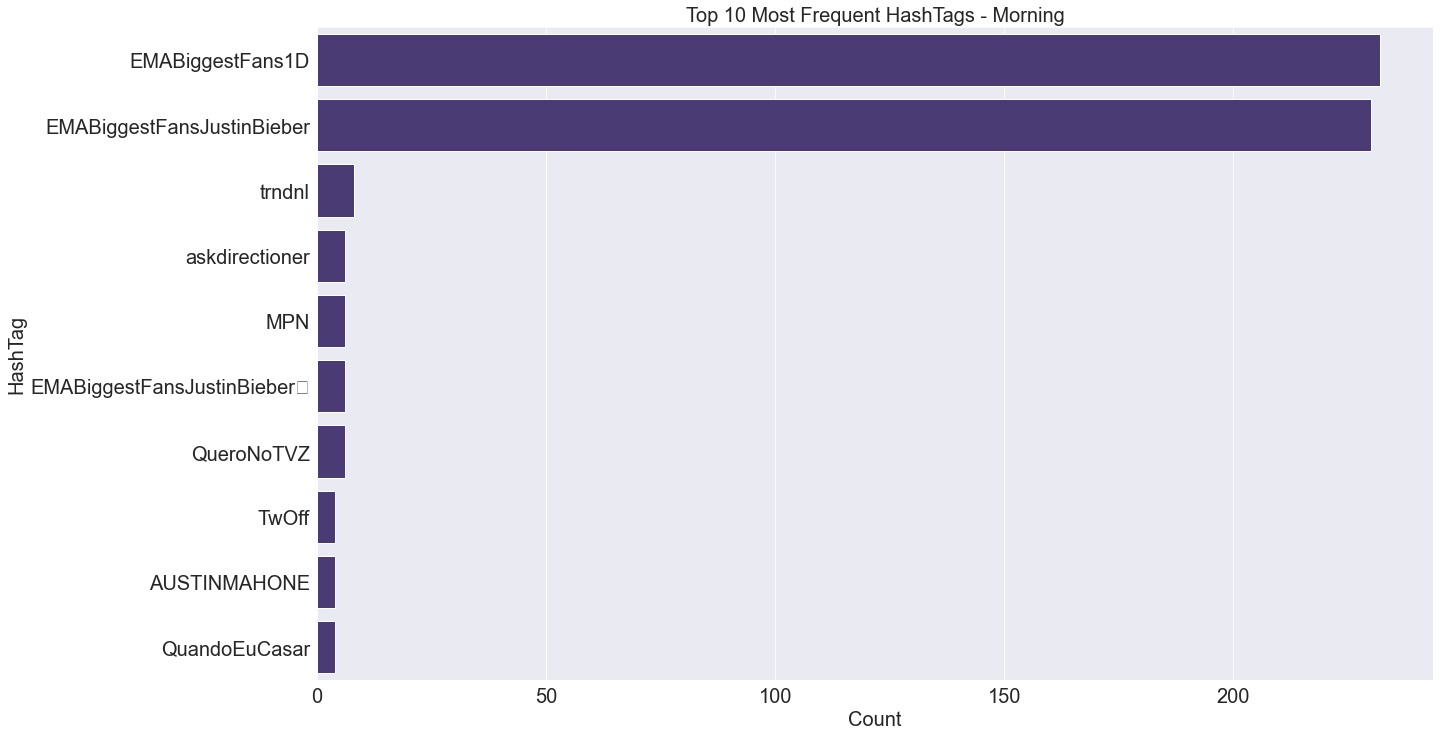

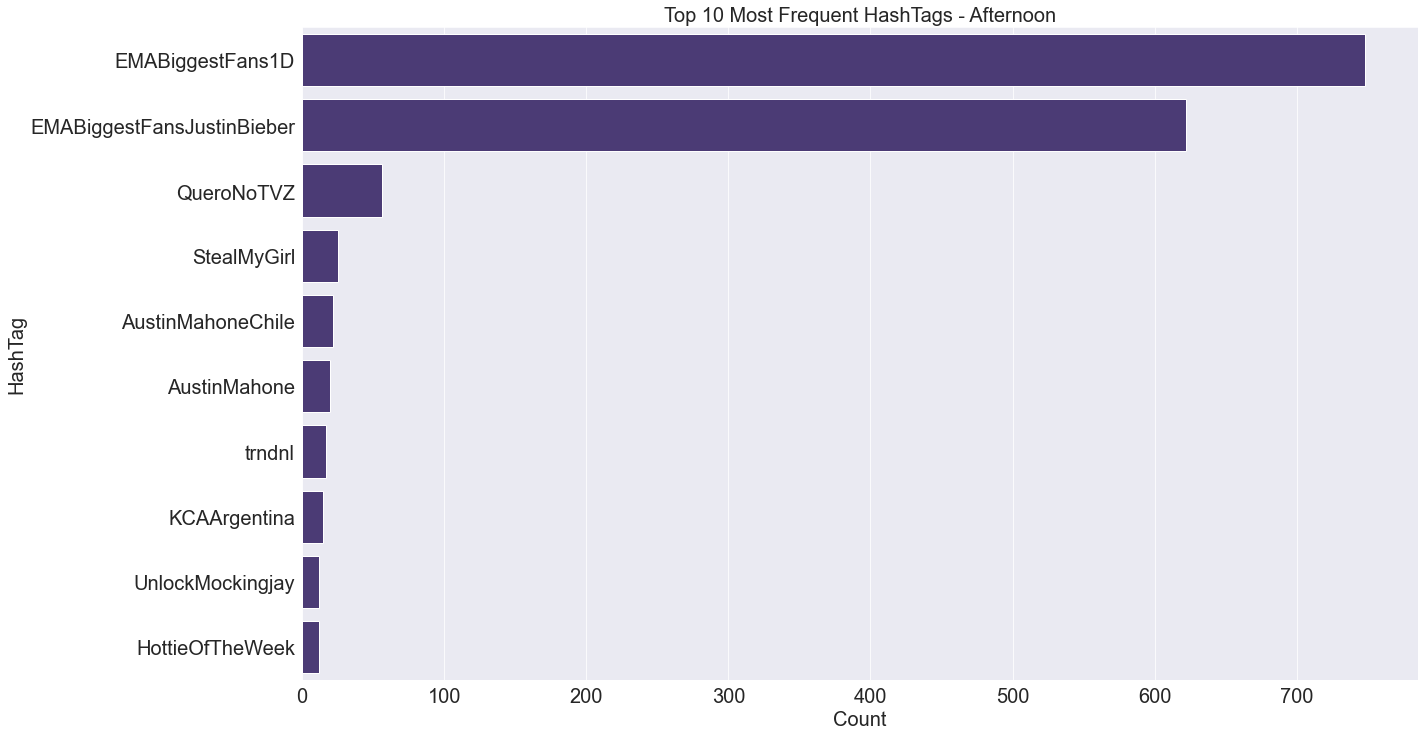

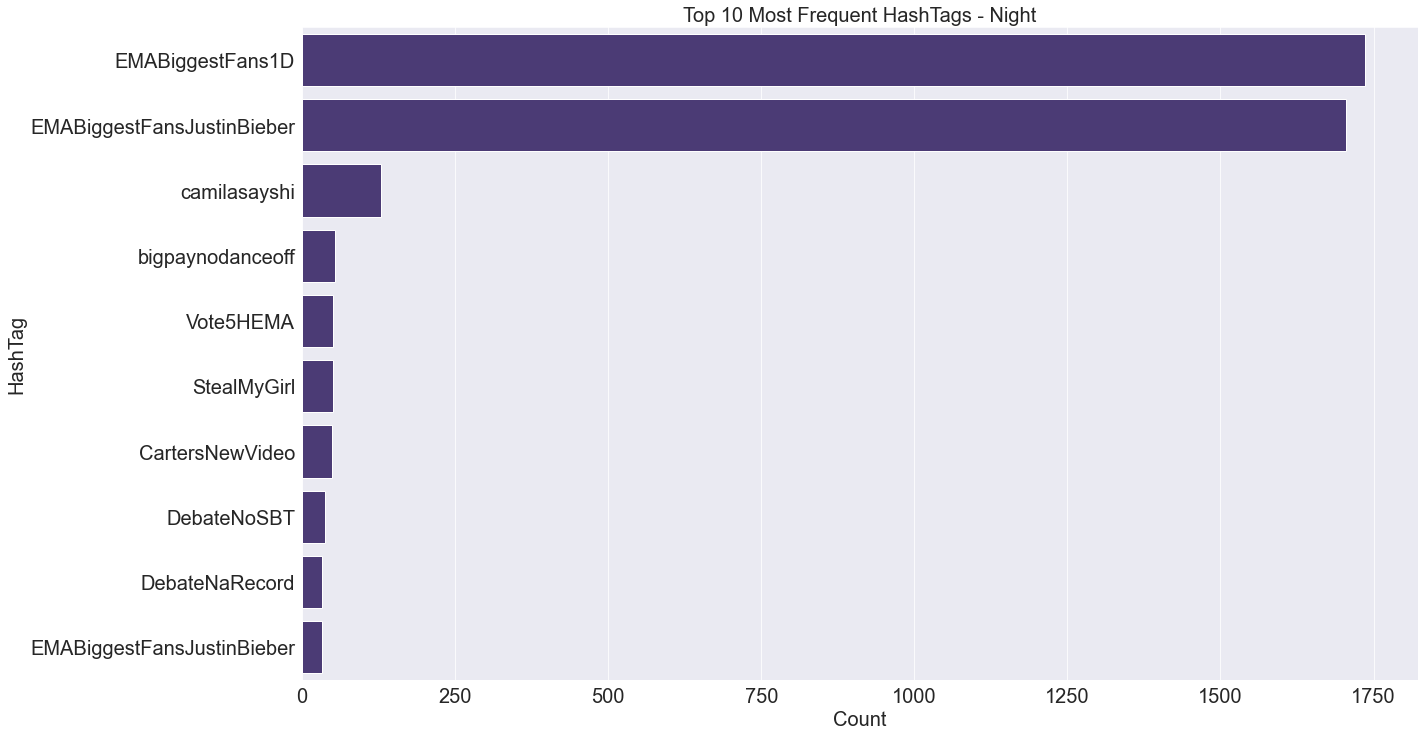

In [ ]:
periodos = ['Morning', 'Afternoon', 'Night']
# make_bar_plot("darkgrid", "viridis", (20,12), 'count', 'hashtag', dfs[0], ('Top 10 Most Frequent HashTags - ' + periodos[0]), 'Count', 'HashTag', 20)

for i, periodo in enumerate(periodos):
    title = f'Top 10 Most Frequent HashTags - {periodo}'
    # Converter o DataFrame para Pandas
    pandas_df = dfs[i]
    make_bar_plot("darkgrid", "viridis", (20, 12), 'count', 'hashtag', pandas_df, title, 'Count', 'HashTag', 20)
